# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [2]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
astunparse                   1.6.3
backcall                     0.2.0
cachetools                   5.3.2
certifi                      2020.6.20
charset-normalizer           3.3.2
colorama                     0.4.6
cycler                       0.11.0
debugpy                      1.5.1
decorator                    5.1.1
entrypoints                  0.4
flatbuffers                  23.5.26
fonttools                    4.38.0
gast                         0.4.0
google-auth                  2.23.4
google-auth-oauthlib         0.4.6
google-pasta                 0.2.0
grpcio                       1.59.3
h5py                         3.8.0
idna                         3.6
importlib-metadata           6.7.0
ipykernel                    6.15.2
ipython                      7.31.1
jedi                         0.18.1
joblib                       1.3.2
jupyter_client               7.4.9
ju

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data' 

In [7]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [8]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [7]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

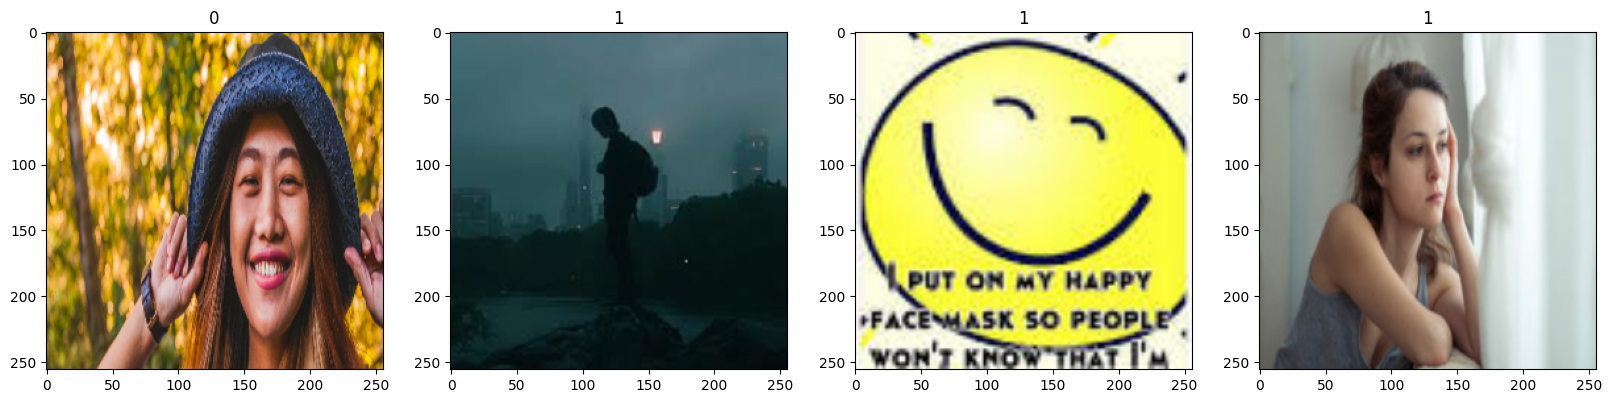

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [10]:
data = data.map(lambda x,y: (x/255, y))

In [11]:
data.as_numpy_iterator().next()

(array([[[[0.90588236, 0.9019608 , 0.8862745 ],
          [0.90631896, 0.9023974 , 0.88671106],
          [0.9105316 , 0.90661   , 0.89092374],
          ...,
          [0.8498085 , 0.82454044, 0.79680604],
          [0.85490197, 0.820481  , 0.7856235 ],
          [0.85490197, 0.81960785, 0.78431374]],
 
         [[0.90588236, 0.9019608 , 0.8862745 ],
          [0.90631896, 0.9023974 , 0.88671106],
          [0.9105316 , 0.90661   , 0.89092374],
          ...,
          [0.8502249 , 0.82495683, 0.7972225 ],
          [0.85490197, 0.820481  , 0.7856235 ],
          [0.85490197, 0.81960785, 0.78431374]],
 
         [[0.9070083 , 0.9030867 , 0.88740045],
          [0.9073195 , 0.9033979 , 0.88771164],
          [0.9105316 , 0.90661   , 0.89092374],
          ...,
          [0.85095394, 0.82568586, 0.7979515 ],
          [0.85490197, 0.8214816 , 0.7846229 ],
          [0.85490197, 0.8207338 , 0.7831878 ]],
 
         ...,
 
         [[0.19059087, 0.15529676, 0.12784578],
          [0.19384

# 5. Split Data

In [12]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [13]:
train_size, val_size, test_size

(7, 2, 1)

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

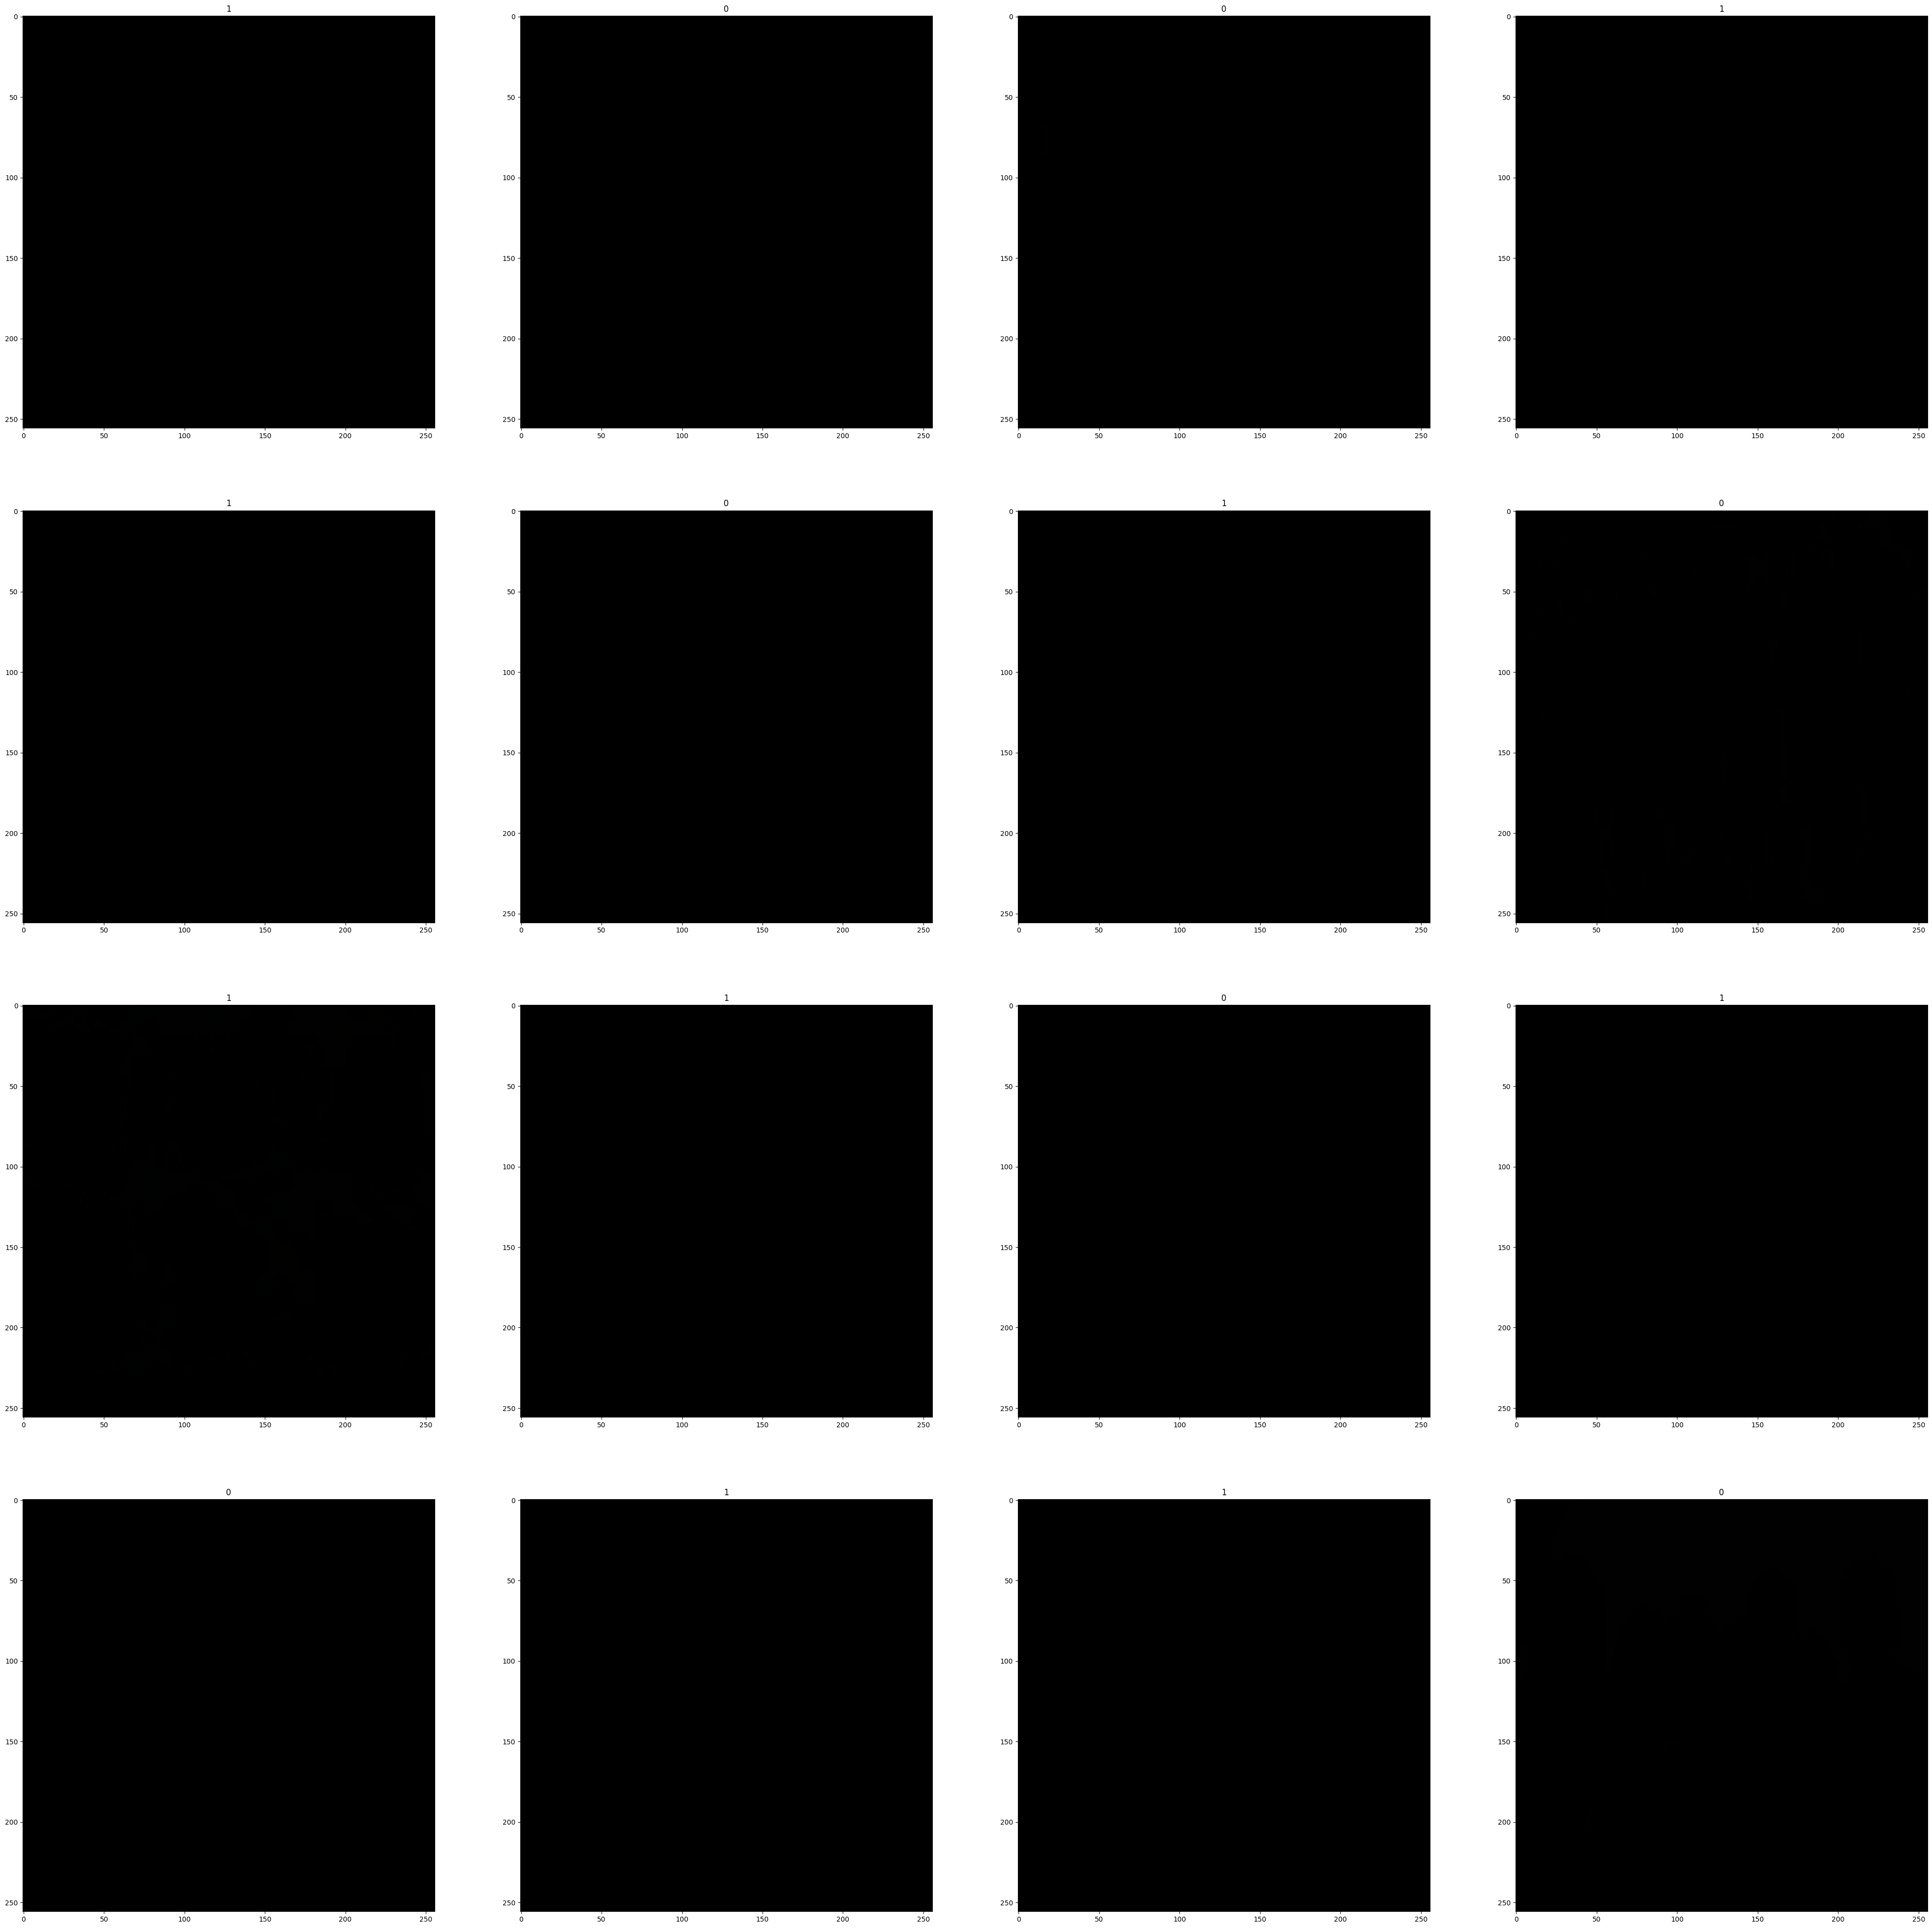

In [30]:
data_iterator  = train.as_numpy_iterator()

batch = data_iterator.next()


fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(50, 50))
for idx, img in enumerate(batch[0][:16]):
    ax[idx // 4, idx % 4].imshow(img.astype(int))
    ax[idx // 4, idx % 4].set_title(batch[1][idx]) 

plt.show()

# 6. Build Deep Learning Model

In [19]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 7s 271ms/step - loss: 1.1782 - accuracy: 0.5268 - val_loss: 0.6669 - val_accuracy: 0.7188
Epoch 2/20
7/7 [==============================] - 2s 193ms/step - loss: 0.6522 - accuracy: 0.5804 - val_loss: 0.6033 - val_accuracy: 0.7344
Epoch 3/20
7/7 [==============================] - 2s 174ms/step - loss: 0.6190 - accuracy: 0.6920 - val_loss: 0.5858 - val_accuracy: 0.7812
Epoch 4/20
7/7 [==============================] - 2s 170ms/step - loss: 0.5640 - accuracy: 0.7723 - val_loss: 0.4510 - val_accuracy: 0.7812
Epoch 5/20
7/7 [==============================] - 2s 169ms/step - loss: 0.4719 - accuracy: 0.8125 - val_loss: 0.3922 - val_accuracy: 0.9219
Epoch 6/20
7/7 [==============================] - 2s 176ms/step - loss: 0.3864 - accuracy: 0.8661 - val_loss: 0.3692 - val_accuracy: 0.8281
Epoch 7/20
7/7 [==============================] - 2s 175ms/step - loss: 0.3845 - accuracy: 0.8348 - val_loss: 0.3282 - val_accuracy: 0.8594
Epoch 8/20
7/7 [====

# 8. Plot Performance

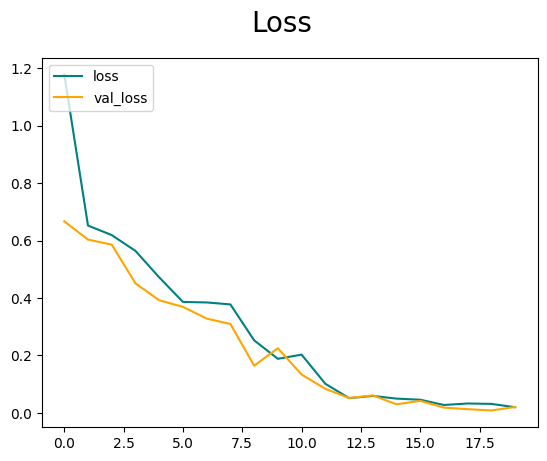

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

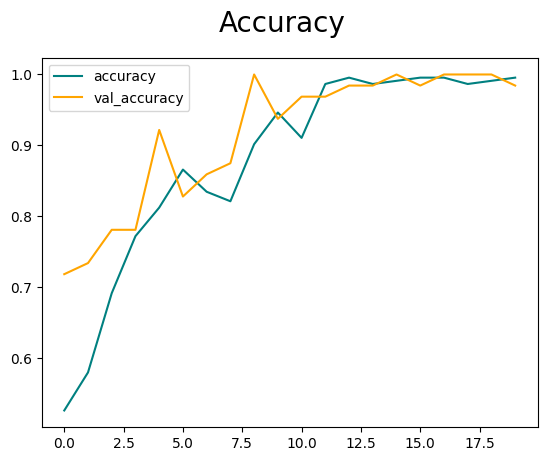

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

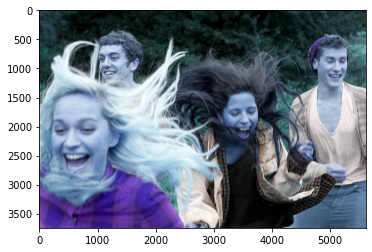

In [39]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

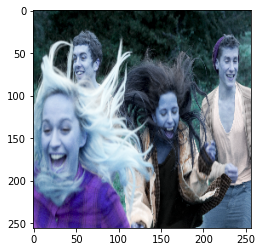

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [42]:
yhat

array([[0.01972741]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)